# Show and Tell - attention based model
## Trained - now reload weights and do inference

### Based on link: https://www.tensorflow.org/tutorials/text/image_captioning

### The model architecture is similar to Show, Attend and Tell: Neural Image Caption Generation with Visual Attention.
#### Arch paper: https://arxiv.org/abs/1502.03044

# Trained model already and saved weights.
# Now reload to do inference

## First phase of training already done and pickled various files to resume training with the data being split in a deterministic manner.

## Will not do all the steps again and simply load all the info from the pickled files:
## Descriptions, image_encodings, embedding_matrix, etc.

### The encoder is pre-trained Google Inception-v3 trained on Imagenet.

## AVAILABLE data :
### Coco_Train2017     = has 118287 images
### Coco_Val2017       = has 5000   images
### Combined total     = 123287     images

## USED data :
### Coco_Train2017     = 100000  images
### Coco_Val2017       = 5000    images
### Combined total     = 105000  images

### Using only the first 100k images of Train2017 + all 5k images of Val2017
### Thus total data available for training = 100k + 5k = 105k
### Details of split of data:
### Training   data = 97000 images from Coco_Train2017
### Validation data = 3000  images from Coco_Train2017
### Test       data = 5000  images from Coco_Val2017

### Note: 1) Each image will have multiple captions (up to 5 as some may be discarded)
###       2) Not using the Coco_Test2017 dataset at all as it has no annotations json file which has the captions.

In [ ]:
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning

#import collections
#import random
#import re
#from glob import glob
#from PIL import Image

In [5]:
import os
import sys
import json
import time
import datetime
import string
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers
import matplotlib.pyplot as plt
import re
import pickle
from glob import glob
import collections
import random
import PIL
#import itertools
#import PIL.Image

In [6]:
#from google.colab import drive
#drive.flush_and_unmount()
#drive.mount('/content/gdrive')

In [7]:
## Kaggle versions

## Weights from training till now
OPDIR = r'/home/rohit/PyWDUbuntu/thesis/ImgCapATTEND_opdir_DUMMY_RUN/'

## New weights to save here
OPDIR_WEIGHTS = r'/home/rohit/PyWDUbuntu/thesis/ImgCapATTEND_opdir_DUMMY_RUN/out_weights_DUMMY_RUN/'

## Training checkpoint directors
CHKPT_DIR = r'/home/rohit/PyWDUbuntu/thesis/ImgCapATTEND_opdir_SMALL/chkPointDir_DUMMY_RUN/train_DUMMY_RUN/'

## Location to save models
#OPDIR_MODEL_SAVE = r'/home/rohit/PyWDUbuntu/thesis/ImgCapATTEND_opdir_DUMMY_RUN/savedModel_DUMMY_RUN/'

## Images locations
IPDIR_IMGS_COCO_TRAIN = r'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/'

## Annotations location
IPDIR_ANNO = r'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/coco_annotations_trainval2017/'

## to make deterministic - saved all the variables based on the data used to train during phase 1
## ALL SUBSEQUENT PHASES WILL RELOAD FROM THE DATA IN THIS LOCATION
IPDIR_DETERMINISTIC_ATTEND = r'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_Deterministic_Run3/'

## Weights from previous stage of training
IPDIR_WEIGHTS_IN = r'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_Weights_In_Run3/'

# CHANGE ENCODINGS LOCATION IF REQUIRED

In [8]:
## New encodings saved in the images folder itself
IPDIR_SAVED_ENCODINGS = IPDIR_IMGS_COCO_TRAIN
IPDIR_SAVED_ENCODINGS

'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/'

# ONE-TIME Prepare the data

In [9]:
PATH = os.path.abspath(IPDIR_IMGS_COCO_TRAIN) + r'/'
PATH

'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/'

In [10]:
!ls '/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/' | wc -l

236574


In [11]:
os.path.exists(PATH + '000000044704.jpg')

True

In [12]:
IPDIR_ANNO

'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/coco_annotations_trainval2017/'

In [13]:
with open(IPDIR_ANNO+'captions_train2017.json', 'r') as f:
    annotations = json.load(f)

In [14]:
print(f"Start time = {datetime.datetime.now().strftime('%H:%M:%S')}")
## Group all captions together having the same image ID.
##    Add the start and end sequence tokens at each end of existing captions
image_path_to_caption = collections.defaultdict(list)
for value in annotations['annotations']:
    caption = f"<start> {value['caption']} <end>"
    image_path = PATH + '%012d.jpg' % (value['image_id'])
    image_path_to_caption[image_path].append(caption)
print(f"End time = {datetime.datetime.now().strftime('%H:%M:%S')}")

Start time = 10:50:17
End time = 10:50:17


In [15]:
type(image_path_to_caption)

collections.defaultdict

In [16]:
list(image_path_to_caption.keys())[:2]

['/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/000000203564.jpg',
 '/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/000000322141.jpg']

In [17]:
list(image_path_to_caption.items())[:2]

[('/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/000000203564.jpg',
  ['<start> A bicycle replica with a clock as the front wheel. <end>',
   '<start> The bike has a clock as a tire. <end>',
   '<start> A black metal bicycle with a clock inside the front wheel. <end>',
   '<start> A bicycle figurine in which the front wheel is replaced with a clock\n <end>',
   '<start> A clock with the appearance of the wheel of a bicycle  <end>']),
 ('/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/000000322141.jpg',
  ['<start> A room with blue walls and a white sink and door. <end>',
   '<start> Blue and white color scheme in a small bathroom. <end>',
   '<start> This is a blue and white bathroom with a wall sink and a lifesaver on the wall. <end>',
   '<start> A blue boat themed bathroom with a life preserver on the wall <end>',
   '<start> A bathroom with walls that are painted baby blue. <end>'])]

In [18]:
print(f"len should be = 118287\nActual value = {len(list(image_path_to_caption.keys()))}")

len should be = 118287
Actual value = 118287


In [19]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Set to very SMALL data for trial run to setup model properly for inference later

In [20]:
train_image_paths = image_paths[:5]

In [21]:
type(train_image_paths)

list

In [23]:
## keeping all the images, not reducing to 30k as the tutorial did
print(f"length should be something tiny\nactual value = {len(train_image_paths)}")

length should be something tiny
actual value = 5


In [24]:
## for all 118k data
train_captions = []
img_name_vector = []
for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

In [25]:
train_image_paths[:2]

['/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/000000474119.jpg',
 '/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/000000338164.jpg']

In [26]:
type(train_captions)

list

In [27]:
train_captions[:2]

['<start> A man sitting on a toilet whle talking on a phone. <end>',
 '<start> A man in a suite sits on a toilet and talks on a landline phone.  <end>']

In [28]:
type(img_name_vector)

list

In [29]:
img_name_vector[:2]

['/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/000000474119.jpg',
 '/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/000000474119.jpg']

In [30]:
len(img_name_vector)

25

<start> A man sitting on a toilet whle talking on a phone. <end>


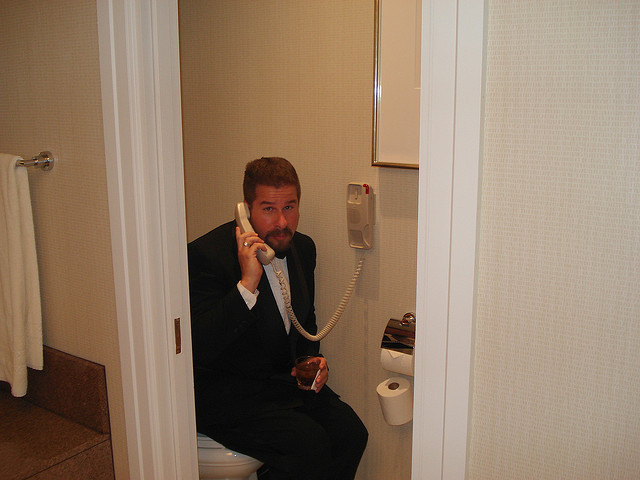

In [31]:
print(train_captions[0])
PIL.Image.open(img_name_vector[0])

# Preprocess and tokenize the captions

### First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
### Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
### You then create word-to-index and index-to-word mappings.
### Finally, you pad all sequences to be the same length as the longest one.

In [32]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [33]:
train_captions[:2]

['<start> A man sitting on a toilet whle talking on a phone. <end>',
 '<start> A man in a suite sits on a toilet and talks on a landline phone.  <end>']

In [34]:
len(train_captions)

25

In [35]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [36]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [37]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [38]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

### max_length = 52 in this case

In [39]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
max_length = 52
print(f"max_length = {max_length}")

max_length = 52


In [40]:
type(tokenizer)

keras_preprocessing.text.Tokenizer

## Split the data into training and testing

### used split ratio of 95:5
### For total 118287 images, there are corresponding
#### Total         data points = 591753 = len(img_name_vector)
#### Train         data points = 562158
#### Validation data points = 29595

In [41]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 95-05 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)
slice_index = int(len(img_keys)*0.95)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [42]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(20, 20, 5, 5)

In [43]:
len(img_to_cap_vector)

5

In [44]:
img_name_train[:2]

['/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/000000357254.jpg',
 '/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/000000357254.jpg']

In [45]:
cap_train[:2]

[array([ 3,  6, 14, 91, 43, 13, 27, 22,  5,  6, 44,  4,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32),
 array([ 3,  6, 14, 92, 93, 94, 95, 27, 96, 45,  4,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)]

# Create a tf.data dataset for training

### Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [46]:
len(img_name_train)

20

In [47]:
img_name_train[:3]

['/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/000000357254.jpg',
 '/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/000000357254.jpg',
 '/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/000000357254.jpg']

In [48]:
type(img_name_train)

list

## OVERWRITE to correct encodings location if it is DIFFERENT
## from the location of the image files itself

In [49]:
IPDIR_SAVED_ENCODINGS

'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/'

In [50]:
## current img_name_train points to the actual .jpg file location.
## Original code expects the .npy file of the saved encoding to also be here - but this is not so in my use case
## so create new list with entries pointing to the encodings location
img_name_train_correct_enc_locs = [IPDIR_SAVED_ENCODINGS + os.path.basename(val) for val in img_name_train]

In [51]:
len(img_name_train_correct_enc_locs)

20

In [52]:
img_name_train_correct_enc_locs[:3]

['/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/000000357254.jpg',
 '/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/000000357254.jpg',
 '/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/000000357254.jpg']

In [53]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 1
BUFFER_SIZE = 250
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [54]:
num_steps

20

In [55]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [56]:
#dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = tf.data.Dataset.from_tensor_slices((img_name_train_correct_enc_locs, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Model
### Fun fact: the decoder below is identical to the one in the example for Neural Machine Translation with Attention (https://www.tensorflow.org/tutorials/sequences/nmt_with_attention).

### The model architecture is inspired by the Show, Attend and Tell paper (https://arxiv.org/pdf/1502.03044.pdf).

### In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
### You squash that to a shape of (64, 2048).
### This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
### The RNN (here GRU) attends over the image to predict the next word.

In [57]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [58]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [59]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [60]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [61]:
type(encoder)

__main__.CNN_Encoder

In [62]:
type(decoder)

__main__.RNN_Decoder

In [63]:
optimizer = tf.keras.optimizers.Adam()

In [64]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [65]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

# Checkpoint

In [66]:
CHKPT_DIR

'/home/rohit/PyWDUbuntu/thesis/ImgCapATTEND_opdir_SMALL/chkPointDir_DUMMY_RUN/train_DUMMY_RUN/'

In [67]:
checkpoint_path = CHKPT_DIR
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [68]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

# Training

### You extract the features stored in the respective .npy files and then pass those features through the encoder.
### The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
### The decoder returns the predictions and the decoder hidden state.
### The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
### Use teacher forcing to decide the next input to the decoder.
### Teacher forcing is the technique where the target word is passed as the next input to the decoder.
### The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [69]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [70]:
@tf.function
def train_step(img_tensor, target):
    global global_saving_flag, global_dec_input, global_features, global_hidden
    loss = 0
    
    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            if global_saving_flag == True:
                global_dec_input = dec_input
                global_features = features
                global_hidden = hidden
                global_saving_flag = False
            
            loss += loss_function(target[:, i], predictions)
            
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
    
    total_loss = (loss / int(target.shape[1]))
    
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss, trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return loss, total_loss

In [71]:
OPDIR_WEIGHTS

'/home/rohit/PyWDUbuntu/thesis/ImgCapATTEND_opdir_DUMMY_RUN/out_weights_DUMMY_RUN/'

In [74]:
global global_saving_flag, global_dec_input, global_features, global_hidden
global_saving_flag = True
global_dec_input = None
global_features = None
global_hidden = None

In [76]:
start_epoch

0

In [77]:
print(f"Using learning rate = {optimizer.learning_rate.numpy()}")

Using learning rate = 0.0010000000474974513


In [78]:
EPOCHS = 1

print(f"Dummy Training Start time = {datetime.datetime.now().strftime('%H:%M:%S')}")
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 1 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 1 == 0:
        ckpt_manager.save()
    
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    ## save the weights
    #decoder.save_weights( OPDIR_WEIGHTS + 'ATTEND_Decoder_wts_ep_' + str(epoch) + '.h5' )
    ## save the model itself
    #decoder.save(
    #    OPDIR_MODEL_SAVE + 'ATTEND_Decoder_wts_ep_' + str(epoch) + '.SavedModel'
    #)
    #decoder.save(
    #    OPDIR_MODEL_SAVE + 'ATTEND_Decoder_wts_ep_' + str(epoch) + '.SavedModel',
    #    features = global_features,
    #    hidden = global_hidden
    #)

print(f"Dummy Training End time = {datetime.datetime.now().strftime('%H:%M:%S')}")

Dummy Training Start time = 10:54:33
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name 'dec_input' is nonlocal and global (tmppfxwc6b8.py, line 21)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name 'dec_input' is nonlocal and global (tmppfxwc6b8.py, line 21)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1 Batch 0 Loss 3.2697
Epoch 1 Batch 1 Loss 3.1290
Epoch 1 Batch 2 Loss 3.4045
Epoch 1 Batch 3 Loss 3.3595
Epoch 1 Batch 4 Loss 2.7266
Epoch 1 Batch 5 Loss 2.7895
Epoch 1 Batch 6 Loss 3.9774
Epoch 1 Batch 7 Loss 2.4512
Epoch 1 Batch 8 Loss 3.3391
Epoch 1 Batch 9 Loss 2.9216
Epoch 1 Batch 10 Loss 2.8530


In [75]:
decoder.summary()

Model: "rnn__decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1280256   
_________________________________________________________________
gru (GRU)                    multiple                  1575936   
_________________________________________________________________
dense_1 (Dense)              multiple                  262656    
_________________________________________________________________
dense_2 (Dense)              multiple                  2565513   
_________________________________________________________________
bahdanau_attention (Bahdanau multiple                  394753    
Total params: 6,079,114
Trainable params: 6,079,114
Non-trainable params: 0
_________________________________________________________________


# Reload necessary stuff
## Tokenizer reload the correct one used during full training run
## Setup correct weights

In [80]:
del tokenizer

In [79]:
IPDIR_DETERMINISTIC_ATTEND

'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_Deterministic_Run3/'

In [81]:
## Reload all the files to make it deterministic

# variable = tokenizer
with open(IPDIR_DETERMINISTIC_ATTEND + 'ATTEND_tokenizer_from_training_100k.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

print(f"Reload success")

Reload success


In [83]:
print(f"{type(tokenizer)}")

<class 'keras_preprocessing.text.Tokenizer'>


In [95]:
WEIGHTS_FILE_RELOAD = IPDIR_WEIGHTS_IN + r'ATTEND_Decoder_wts_ep_2.h5'
WEIGHTS_FILE_RELOAD

'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_Weights_In_Run3/ATTEND_Decoder_wts_ep_2.h5'

In [96]:
decoder.load_weights(WEIGHTS_FILE_RELOAD)
print(f"Success reloading weights")

Success reloading weights


# Setup encoder related stuff

In [88]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [89]:
## Initialize InceptionV3 and load the pretrained Imagenet weights
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
type(image_model)

tensorflow.python.keras.engine.functional.Functional

# Caption

### The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
### Stop predicting when the model predicts the end token.
### And store the attention weights for every time step.

In [90]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [91]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [93]:
new_image = r'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000016.jpg'

In [ ]:
## wts epoch - 4

image = new_image
#real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)
print(f"Model predicted caption =\n{result}")
PIL.Image.open(new_image)

Model predicted caption =
['a', 'freshly', 'with', 'a', 'sign', 'that', 'is', 'laying', 'next', 'to', '<unk>', 'by', 'faced', 'near', 'very', 'close', 'up', 'view', 'busy', 'counters', 'laying', 'sits', 'in', 'the', 'street', 'stands', 'on', 'a', 'covered', 'in', 'to', 'a', 'street', 'peanut', 'are', 'variety', 'a', 'pile', 'of', 'traffic', 'eating', 'the', 'cow', 'is', 'sitting', 'calmly', 'sitting', 'on', 'bike', 'wearing', 'baseball', 'glider']


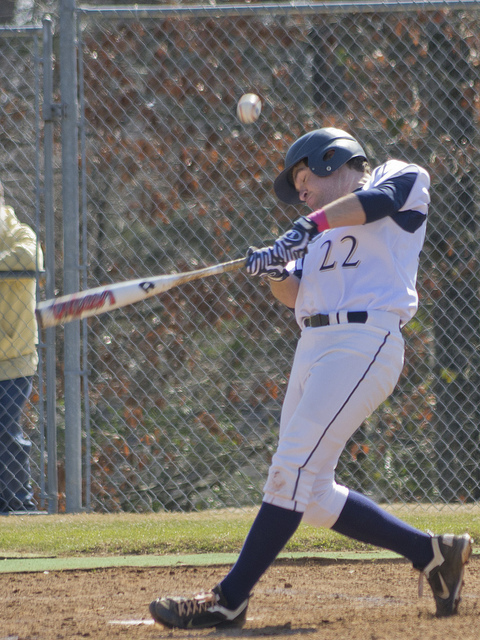

In [94]:
## wts epoch - 4

image = new_image
#real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)
print(f"Model predicted caption =\n{result}")
PIL.Image.open(new_image)

Model predicted caption =
['a', 'standing', 'in', 'green', 'and', 'a', '<unk>', 'come', 'stand', 'at', 'the', 'beach', 'full', 'of', '<unk>', 'behind', 'a', 'woman', 'on', 'top', 'is', 'sitting', 'on', 'a', 'dark', 'shorts', 'laying', 'next', 'to', 'beers', 'while', 'people', 'walking', 'behind', 'young', 'is', 'on', 'a', 'black', '<end>']


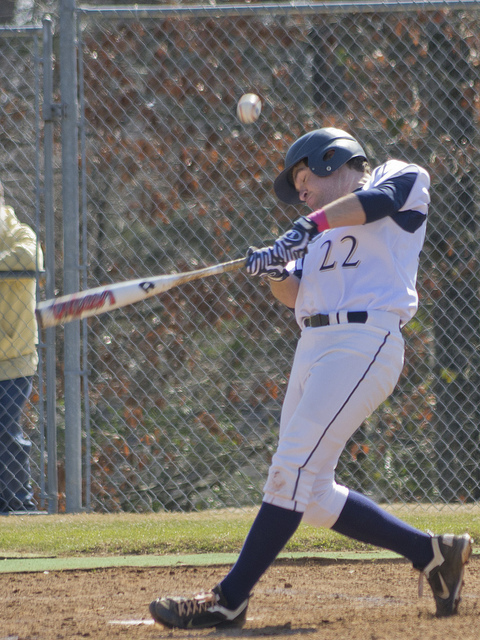

In [97]:
## wts epoch - 2

image = new_image
#real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)
print(f"Model predicted caption =\n{result}")
PIL.Image.open(new_image)

Model predicted caption =
['bike', 'in', 'bike', '<end>']


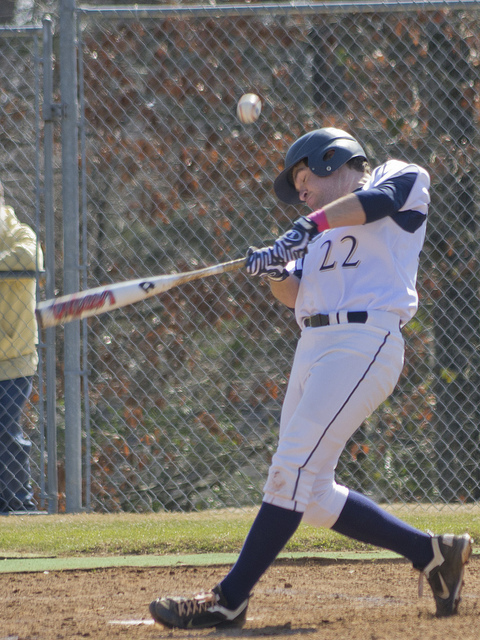

In [100]:
## small earlier run

new_image = r'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000016.jpg'
image = new_image
#real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)
print(f"Model predicted caption =\n{result}")
PIL.Image.open(new_image)

In [80]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


NameError: name 'load_image' is not defined

# Try it on your own images
### For fun, below we've provided a method you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [ ]:
reloaded_RNN_decoder = reload_rnn_encoder_for_more_training(RELOAD_WEIGHTS_FILE_PATH, EMBEDDING_DIMS, VOCAB_SIZE, MAX_LENGTH_CAPTION)
if reloaded_RNN_decoder is None:
    print(f"FATAL ERROR setting up Decoder")
else:
    print(f"\n{type(reloaded_RNN_decoder)}")

In [ ]:
## Output of command:  model_RNN_decoder.summary() AFTER FREEZING THE EMBEDDINGS WEIGHTS
## NOTE the count of Trainable params has REDUCED
reloaded_RNN_decoder.summary()

In [ ]:
## Output of command:  model_RNN_decoder.summary() AFTER FREEZING THE EMBEDDINGS WEIGHTS
## NOTE the count of Trainable params has REDUCED

#Model: "functional_3"
#__________________________________________________________________________________________________
#Layer (type)                    Output Shape         Param #     Connected to                     
#==================================================================================================
#input_4 (InputLayer)            [(None, 49)]         0                                            
#__________________________________________________________________________________________________
#input_3 (InputLayer)            [(None, 2048)]       0                                            
#__________________________________________________________________________________________________
#embedding_1 (Embedding)         (None, 49, 200)      1351600     input_4[0][0]                    
#__________________________________________________________________________________________________
#dropout_2 (Dropout)             (None, 2048)         0           input_3[0][0]                    
#__________________________________________________________________________________________________
#dropout_3 (Dropout)             (None, 49, 200)      0           embedding_1[0][0]                
#__________________________________________________________________________________________________
#dense_3 (Dense)                 (None, 256)          524544      dropout_2[0][0]                  
#__________________________________________________________________________________________________
#lstm_1 (LSTM)                   (None, 256)          467968      dropout_3[0][0]                  
#__________________________________________________________________________________________________
#add_1 (Add)                     (None, 256)          0           dense_3[0][0]                    
#                                                                 lstm_1[0][0]                     
#__________________________________________________________________________________________________
#dense_4 (Dense)                 (None, 256)          65792       add_1[0][0]                      
#__________________________________________________________________________________________________
#dense_5 (Dense)                 (None, 6758)         1736806     dense_4[0][0]                    
#==================================================================================================
#Total params: 4,146,710
#Trainable params: 2,795,110
#Non-trainable params: 1,351,600
#__________________________________________________________________________________________________

In [ ]:
#tf.keras.utils.plot_model(reloaded_RNN_decoder, to_file=OPDIR+'RNN_decoder_model3_plot_1.png', show_shapes=True, show_layer_names=True)

### ALWAYS - Compile RNN model

In [ ]:
## setup the optimizer and compile

## see the default LR used, set some dummy to check it works
optimizer_adam = tf.keras.optimizers.Adam()  ## if nothing specified the default LR = 0.001
reloaded_RNN_decoder.compile(loss='categorical_crossentropy', optimizer=optimizer_adam)
print(f"Default LR without explicity setting so far = {reloaded_RNN_decoder.optimizer.learning_rate.numpy()}")

optimizer_adam.learning_rate.assign(0.5)
print(f"After setting LR as 0.5 = {reloaded_RNN_decoder.optimizer.learning_rate.numpy()}")

## ALWAYS - Train the RNN Decoder

In [ ]:
OPDIR_WEIGHTS

In [ ]:
os.listdir( OPDIR_WEIGHTS )

In [ ]:
## values setup earlier - for reference

print(f"\tEncodings data:\nlen(img_encodings_train) = {len(img_encodings_train)}\nlen(img_encodings_val) = {len(img_encodings_val)}")
print(f"\tDescriptions data:\nlen(descriptions_train) = {len(descriptions_train)}\nlen(descriptions_val) = {len(descriptions_val)}")

print(f"\nNO Validation Set being used for now.\n")

print(f"len(wordtoix) = {len(wordtoix)}")
print(f"VOCAB_SIZE = {VOCAB_SIZE}")
print(f"EMBEDDING_DIMS = {EMBEDDING_DIMS}")
print(f"embedding_matrix Shape = {embedding_matrix.shape}")
print(f"MAX_LENGTH_CAPTION = {MAX_LENGTH_CAPTION}")

print(f"\nInitialed with this input weights file:\n{RELOAD_WEIGHTS_FILE_PATH}")

In [ ]:
MODEL_RUN_NUMBER = 3 ## large training data - 97k train
MODEL_RUN_NUMBER

In [ ]:
## Specify the last epoch number (index from 1, NOT 0) so that the output weights files will have the correct epoch number for tracking
## E.g. if earlier phase ran up to Ep 7, then specify below as 7
EARLIER_TRAINING_EPOCH_END = 18
EARLIER_TRAINING_EPOCH_END

In [ ]:
########### Phase 10 #########

print(f"\n\nMODEL {MODEL_RUN_NUMBER} :: Training Phase 10 started at :: {datetime.datetime.now().strftime('%H:%M:%S')}\n")

LR_10 = 0.0005
BATCH_SIZE_10 = 16   ## how many images per batch
N_EPOCHS_10 = 2
STEPS_PER_EPOCH_10 = len(descriptions_train) // BATCH_SIZE_10
print(f"\nPhase 10 parameters:")
print(f"STEPS_PER_EPOCH_10 = {STEPS_PER_EPOCH_10}")
print(f"BATCH_SIZE_10 = {BATCH_SIZE_10}")
print(f"N_EPOCHS_10 = {N_EPOCHS_10}")
print(f"EARLIER_TRAINING_EPOCH_END = {EARLIER_TRAINING_EPOCH_END}")

optimizer_adam.learning_rate.assign(LR_10)

for i in range( EARLIER_TRAINING_EPOCH_END , EARLIER_TRAINING_EPOCH_END + N_EPOCHS_10 ):
    print(f"\nEpoch {i+1} started at {datetime.datetime.now().strftime('%H:%M:%S')}\nLR used = {reloaded_RNN_decoder.optimizer.learning_rate.numpy()}\n")
    generator_1 = data_generator_1(descriptions_train, img_encodings_train, wordtoix, MAX_LENGTH_CAPTION, BATCH_SIZE_10, VOCAB_SIZE)
    reloaded_RNN_decoder.fit_generator(generator_1, epochs=1, steps_per_epoch=STEPS_PER_EPOCH_10, verbose=1)
    
    reloaded_RNN_decoder.save_weights( OPDIR_WEIGHTS + 'Decoder_Run_' + str(MODEL_RUN_NUMBER) + '_Wt_ep_' + str(i+1) + '.h5' )

In [ ]:
########### Phase 10 #########   --- NOTE changed BS = 16 from 32

MODEL 3 :: Training Phase 10 started at :: 20:39:35


Phase 10 parameters:
STEPS_PER_EPOCH_10 = 6062
BATCH_SIZE_10 = 16
N_EPOCHS_10 = 2
EARLIER_TRAINING_EPOCH_END = 18

Epoch 19 started at 20:39:35
LR used = 0.0005000000237487257

6062/6062 [==============================] - 9275s 2s/step - loss: 2.8152

Epoch 20 started at 23:14:17
LR used = 0.0005000000237487257

2099/6062 [=========>....................] - ETA: 1:41:54 - loss: 2.7689


# KEEP TRACK OF EARLIER PHASE TRAINING

In [ ]:
let it fail if run accidentally

COMMON stuff

        Encodings data:
len(img_encodings_train) = 97000
len(img_encodings_val) = 3000
        Descriptions data:
len(descriptions_train) = 97000
len(descriptions_val) = 3000

No Validation Set being used for now.

len(wordtoix) = 6757
VOCAB_SIZE = 6758
EMBEDDING_DIMS = 200
embedding_matrix Shape = (6758, 200)
MAX_LENGTH_CAPTION = 49

                Before freezing:
#Total params: 4,146,710
#Trainable params: 4,146,710
#Non-trainable params: 0

                After freezing:
#Total params: 4,146,710
#Trainable params: 2,795,110
#Non-trainable params: 1,351,600

************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************

Phase 1:  -- had set to run 3 epochs but only epoch 1/3 weight file avaliable.

LR_1 = 0.001
BATCH_SIZE_1 = 64   ## how many images per batch
N_EPOCHS_1 = 3
Adam optimizer


MODEL 2 :: Training Phase 1 started at :: 22:44:01


Phase 1 parameters:
LR_1 = 0.001
STEPS_PER_EPOCH_1 = 1515
BATCH_SIZE_1 = 64
N_EPOCHS_1 = 3

Epoch 1 started at 22:44:01
LR used = 0.0010000000474974513 

1515/1515 [==============================] - 7900s 5s/step - loss: 3.7964				only able to save this weights file

Epoch 2 started at 00:55:53
LR used = 0.0010000000474974513 

1515/1515 [==============================] - 7890s 5s/step - loss: 3.1811

Epoch 3 started at 03:07:29
LR used = 0.0010000000474974513 

1515/1515 [==============================] - 7911s 5s/step - loss: 3.0520

************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************

Phase 2:  -- had set to run 4 epochs but only epoch till epoch 2/4 weight file avaliable.

Phase 2 parameters:
STEPS_PER_EPOCH_2 = 1515
BATCH_SIZE_2 = 64
N_EPOCHS_2 = 4

Epoch 2 started at 11:59:50
LR used = 0.0010000000474974513

1515/1515 [==============================] - 6942s 5s/step - loss: 3.1985

Epoch 3 started at 13:55:42
LR used = 0.0010000000474974513

1515/1515 [==============================] - 7026s 5s/step - loss: 3.0458

Epoch 4 started at 15:52:52
LR used = 0.0010000000474974513

 643/1515 [===========>..................] - ETA: 1:07:01 - loss: 2.9839				failed midway

************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************

Phase 3:   -- had set to run 4 epochs but only epoch till epoch 2/4 weight file avaliable.

MODEL 3 :: Training Phase 3 started at :: 19:28:15


Phase 3 parameters:
STEPS_PER_EPOCH_3 = 1515
BATCH_SIZE_3 = 64
N_EPOCHS_3 = 4

Epoch 4 started at 19:28:15
LR used = 0.0010000000474974513

1515/1515 [==============================] - 7071s 5s/step - loss: 3.0032

Epoch 5 started at 21:26:17
LR used = 0.0010000000474974513

1515/1515 [==============================] - 7088s 5s/step - loss: 2.9399

Epoch 6 started at 23:24:30
LR used = 0.0010000000474974513

 163/1515 [==>...........................] - ETA: 1:44:44 - loss: 2.8966              FAILED MIDWAY - ONLY TILL EP 5 WEIGHTS SAVED


************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************

Phase 4:   -- had set to run 3, seems to completed properly with all weight files saved. Only prob is showed a Failed to Fetch message during last ep, but continued runninng. Ignoring the problem

MODEL 3 :: Training Phase 4 started at :: 00:10:53


Phase 4 parameters:
STEPS_PER_EPOCH_4 = 1515
BATCH_SIZE_4 = 64
N_EPOCHS_4 = 3
EARLIER_TRAINING_EPOCH_END = 5

Epoch 6 started at 00:10:53
LR used = 0.0010000000474974513

1515/1515 [==============================] - 7917s 5s/step - loss: 2.9315

Epoch 7 started at 02:23:01
LR used = 0.0010000000474974513

1515/1515 [==============================] - 7941s 5s/step - loss: 2.8899

Epoch 8 started at 04:35:28
LR used = 0.0010000000474974513

1515/1515 [==============================] - 7963s 5s/step - loss: 2.8673


************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************

Phase 5:  -- had set to run 3 epochs - ALL ran successfully

MODEL 3 :: Training Phase 5 started at :: 09:07:50


Phase 5 parameters:
STEPS_PER_EPOCH_5 = 1515
BATCH_SIZE_5 = 64
N_EPOCHS_5 = 3
EARLIER_TRAINING_EPOCH_END = 8

Epoch 9 started at 09:07:50
LR used = 0.0010000000474974513

1515/1515 [==============================] - 7870s 5s/step - loss: 2.8728

Epoch 10 started at 11:19:13
LR used = 0.0010000000474974513

1515/1515 [==============================] - 7869s 5s/step - loss: 2.8443

Epoch 11 started at 13:30:28
LR used = 0.0010000000474974513

 741/1515 [=============>................] - ETA: 1:07:06 - loss: 2.8187

************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************

########### Phase 6 #########

MODEL 3 :: Training Phase 6 started at :: 18:01:53


Phase 6 parameters:
STEPS_PER_EPOCH_6 = 1515
BATCH_SIZE_6 = 64
N_EPOCHS_6 = 4
EARLIER_TRAINING_EPOCH_END = 11

Epoch 12 started at 18:01:53
LR used = 0.0010000000474974513

1515/1515 [==============================] - 7179s 5s/step - loss: 2.8397

Epoch 13 started at 20:01:42
LR used = 0.0010000000474974513

1515/1515 [==============================] - 7219s 5s/step - loss: 2.8169      --- only downloaded till here

Epoch 14 started at 22:02:06
LR used = 0.0010000000474974513

1515/1515 [==============================] - 7190s 5s/step - loss: 2.8059

Epoch 15 started at 00:02:01
LR used = 0.0010000000474974513

1515/1515 [==============================] - 7146s 5s/step - loss: 2.7968

************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************


########### Phase 7 #########   --- NOTE changed BS = 128 from 64

MODEL 3 :: Training Phase 7 started at :: 04:01:59


Phase 7 parameters:
STEPS_PER_EPOCH_7 = 757
BATCH_SIZE_7 = 128
N_EPOCHS_7 = 2
EARLIER_TRAINING_EPOCH_END = 13

Epoch 14 started at 04:01:59
LR used = 0.0010000000474974513

757/757 [==============================] - 8378s 11s/step - loss: 2.8013

Epoch 15 started at 06:22:00
LR used = 0.0010000000474974513

267/757 [=========>....................] - ETA: 1:29:49 - loss: 2.7637        --- failed midway

************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************

########### Phase 8 #########   --- NOTE changed BS = 128 from 64

MODEL 3 :: Training Phase 8 started at :: 08:33:07


Phase 8 parameters:
STEPS_PER_EPOCH_8 = 757
BATCH_SIZE_8 = 128
N_EPOCHS_8 = 1
EARLIER_TRAINING_EPOCH_END = 14

Epoch 15 started at 08:33:07
LR used = 0.0010000000474974513

757/757 [==============================] - 8268s 11s/step - loss: 2.7950

************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************

########### Phase 8 #########   --- NOTE changed BS = 32 from 64

MODEL 3 :: Training Phase 9 started at :: 11:12:47


Phase 9 parameters:
STEPS_PER_EPOCH_9 = 3031
BATCH_SIZE_9 = 32
N_EPOCHS_9 = 3
EARLIER_TRAINING_EPOCH_END = 15

Epoch 16 started at 11:12:47
LR used = 0.0005000000237487257

3031/3031 [==============================] - 7951s 3s/step - loss: 2.7977

Epoch 17 started at 13:25:26
LR used = 0.0005000000237487257

3031/3031 [==============================] - 8119s 3s/step - loss: 2.7796

Epoch 18 started at 15:40:48
LR used = 0.0005000000237487257

3031/3031 [==============================] - 8965s 3s/step - loss: 2.7704


************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************
************************************************************************************************


In [ ]:
#model_reset_states
#lr optimizer
#tuner